# Identifiability of parameters

In this notebook we execute a practical identifiability analysis for the differentiation rates $Q_{ij}$.

## Steps:

* Fit a chosen model to real data (done in other notebooks)
* For each parameter, choose a range of alternative parameter values
* Simulate data for each instance in the range
* Fit model to simulated data
* Compare ground-truth parameter value with estimated value


In this notebook, we analyse both CD4 and CD8 data and models.

This notebook requires estimates from the SA models, and hence we first have to run the notebooks

* `SequentialApproachFitting.ipynb` for the (primary) CD8 fits
* `SequentialApproachFitCD4.ipynb` for the CD4 fits

In [7]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import os
import pandas as pd

from scdynsys import identifiability as ident

## Import the data

Results from fits are written to the `results` folder by the aforementioned notebooks

In [2]:
data_files = {
    "CD8" : "../results/data_SA_fitting.pkl",
    "CD4" : "../results/data_SA_fitting_CD4.pkl"
}

lineages = ["CD8", "CD4"]

datasets = {}

for lineage in lineages:
    data_file = data_files[lineage]
    with open(data_file, 'rb') as f:
        data = pickle.load(f)
    datasets[lineage] = data
    

t0 = 8.0

In [3]:
# get a point estimate for the parameters

focal_models = {
    "CD8" : "M4",
    "CD4" : "M3"
}

def get_required_data(lineage, model):
    fit_results = datasets[lineage]["fit_results"]
    par_dict, init_guess, data, diag_dict = fit_results[model]
    pd_gt = ident.get_point_est(par_dict, diag_dict, method="median")
    tidxs = np.array(data["Idxf"])
    tobs_unique = np.array(data["T"])

    required_data = {
        "num_pops" : data["C"],
        "tobs_unique" : tobs_unique,
        "tidxs" : tidxs,
        "tobs" : tobs_unique[tidxs-1],
        "flow_sample_sizes" : np.sum(data["ClusFreq"], axis=0),
        "pd_gt" : pd_gt,
        "t0" : data["T0"],
    }
    return required_data

required_data = {
    lineage : get_required_data(lineage, focal_models[lineage])
    for lineage in lineages
}

## Perturbation-based identifiability analysis


### Simulate data

Perturb one of the parameters, and simulate data for each perturbation

In [4]:
pd_perturb_dict = {}
pseudo_data_dict = {}

num_reps = 51

perturb_range = 0.75 ## i.e. 1 + 0.75 fold change

for lineage in lineages:
    print(f"simulating data for lineage {lineage}")
    rdat = required_data[lineage]
    num_pops = rdat["num_pops"]
    idxs = [(i,j) for i in range(num_pops) for j in range(num_pops) if i != j]
    pd_gt = rdat["pd_gt"]
    model = focal_models[lineage]
    t0 = rdat["t0"]
    tobs = rdat["tobs"]
    flow_sample_sizes = rdat["flow_sample_sizes"]
    count_scaling = datasets[lineage]["count_scaling"]
    for i, j in tqdm.tqdm(idxs):
        pd_perts = ident.perturb_param(pd_gt, "Q", perturb_range, num_reps, i=i, j=j)
        for r, pd in enumerate(pd_perts):
            sim = ident.generate_pseudo_data(model, pd, t0, tobs, flow_sample_sizes, count_scaling)
            # add model and count_scaling to sim
            sim["model"] = model
            sim["count_scaling"] = count_scaling
            pd_perturb_dict[(lineage, "Q", r, i, j)] = pd
            pseudo_data_dict[(lineage, "Q", r, i, j)] = sim

simulating data for lineage CD8


  0%|          | 0/56 [00:00<?, ?it/s]

100%|██████████| 56/56 [05:57<00:00,  6.38s/it]


simulating data for lineage CD4


100%|██████████| 110/110 [06:09<00:00,  3.36s/it]


Show the number of simulated dataset (and hence the number of fits we have to do)

In [5]:
num_simulations = len(pseudo_data_dict)

print("number of fits required:", num_simulations)

number of fits required: 8466


### Now we have to fit the models to the simulated datasets

As we have *A LOT* of fits to do, this will be executed on a HPC cluster.

<div class="alert alert-block alert-info"> <b>NOTE</b> 
    This step can be skipped if you want to use the pre-fitted models
</div>

For this to work, you have to take make sure the `scdynsys` package is installed in your HPC environment
(in a virtual environment called `venv`), and a local version of `cmdstan` has to be installed. 
This is possible by specifying the installation folder in the `cmdstanpy.install_cmdstan` function. 
Also make sure you set the right version (the specific Stan version *should* not be too important, 
as long as it is recent enough)

The directory (`folder`) from which you'll run this also has to have `identifiability`,
`identifiability/output`, and `identifiability/results` sub directories.

One issue with this analysis is that it would take *a lot of disk space* if we were to save everything. 
Therefore, we try to clean up as much as necessary.

<div class="alert alert-block alert-info"> <b>NOTE</b> 
    Make sure that <code>folder</code> and <code>slurm_partition</code> are set correctly.
</div>


In [ ]:
folder = "/path/to/mesh/directory" ## system dependent
slurm_partition = "my_fav_partition" ## system dependent


data_file_path = os.path.join(folder, "identifiability/pseudo_data_dict.pkl")
with open(data_file_path, 'wb') as f:
    pickle.dump(pseudo_data_dict, f)


slurm_script = f"""#!/bin/bash

#SBATCH --output={folder}/identifiability/output/fit-stan-ia.%A.%a.out
#SBATCH --job-name trm-stan-fit-ia
#SBATCH --ntasks=1
#SBATCH --array=0-{num_simulations-1}%100
#SBATCH --cpus-per-task=5
#SBATCH --partition={slurm_partition}

cd {folder}
source venv/bin/activate

export CMDSTAN='.cmdstan/cmdstan-2.36.0/'

python3 identifiability/py_script.py $SLURM_ARRAY_TASK_ID
"""

slurm_file_path = os.path.join(folder, "identifiability/slurm_script.sh")
with open(slurm_file_path, 'w') as f:
    f.write(slurm_script)

py_script = f"""import dynscsvi.identifiability as ident
import sys
import pickle
import shutil

idx = int(sys.argv[1])

print("running fit with index", idx)

with open("identifiability/pseudo_data_dict.pkl", 'rb') as f:
    pseudo_data_dict = pickle.load(f)

keys = sorted(list(pseudo_data_dict.keys()))
key = keys[idx]
pseudo_data = pseudo_data_dict[key]

print("this index corresponds with key", key)

key_str = "_".join([str(x) for x in key])

stan_cache = "identifiability/stan_cache/" + key_str

stan_kwargs = dict(output_dir=stan_cache, refresh=100, thin=5)

par_dict, inits, stan_data, diag_dict = ident.fit_model_to_psuedo_data(**pseudo_data, stan_kwargs=stan_kwargs)

print("stan fit complete")

# save some disk space by removing unnecessary variables
for var in ["X", "freqs", "rates", "counts", "counts_sim"]:
    par_dict.pop(var)

# cleanup the stan cache
try:
    shutil.rmtree(stan_cache)
    print("directory", stan_cache, "and all its contents have been removed successfully")
except OSError as e:
    print("error:", e.strerror)

with open("identifiability/results/fit_" + key_str + ".pkl", 'wb') as f:
    pickle.dump(par_dict, f)
"""

py_file_path = os.path.join(folder, "identifiability/py_script.py")
with open(py_file_path, 'w') as f:
    f.write(py_script)


### Run the model fits on a HPC cluster

<div class="alert alert-block alert-warning"> <b>WARNING</b> 
    This will take a lot of time
</div>

Make sure to compile the Stan model before running the fits with sbatch, otherwise Stan will try to write to the same executable many times.


In [ ]:
%%bash -s "$folder"

cd $1 # enter the folder specified by the user (see above)
source venv/bin/activate
export CMDSTAN='.cmdstan/cmdstan-2.36.0/'
python -c 'from dynscsvi.stanfit import compile_stan_model; compile_stan_model()'

sbatch identifiability/slurm_script.sh

Submitted batch job 75376


### Collect the fitting results

In [88]:
from scipy.special import logsumexp

keys = sorted(list(pseudo_data_dict.keys()))

result_file_dict = {
    k : f"fit_{k[0]}_{k[1]}_{k[2]}_{k[3]}_{k[4]}.pkl"
    for k in keys
}

def load_estimate(k):
    file_path = os.path.join(folder, "identifiability/results", result_file_dict[k])
    with open(file_path, 'rb') as f:
        fit = pickle.load(f)
    match k:
        case (lin, var, rep):
            sams = fit[var]
        case (lin, var, rep, i):
            sams = fit[var][:,i]
        case (lin, var, rep, i, j):
            sams = sams = fit[var][:,i,j]
    loglik = logsumexp(np.sum(fit["log_lik"], axis=1)) - np.log(len(sams))
    return sams, loglik

estimate_dict = {
    k : load_estimate(k)
    for k in keys
}

### Save estimates to a file

Which we can e.g. put in a data repository

In [ ]:
# create a pandas data frame with the estimates and loglikelihoods

def format_key(k):
    return "_".join(map(str, k))

estimates = pd.DataFrame(
    {format_key(k): np.concatenate(([estimate_dict[k][1]], estimate_dict[k][0])) for k in keys},
    index=[f"loglik"] + [f"sam_{i}" for i in range(len(next(iter(estimate_dict.values()))[0]))]
)

# save the data frame to a hdf5 file

## UNCOMMENT THIS TO SAVE THE FILE

#estimates.to_hdf("../data/estimates_identifiability.hdf5", key="df", mode='w')

### Import pre-fitted models

<div class="alert alert-block alert-info"> <b>NOTE</b> 
    Continue with this cell if you skipped the fitting step on the HPC
</div>

In [9]:
# import the data frame from the hdf5 file

estimates = pd.read_hdf("../data/estimates_identifiability.hdf5", key="df")

# convert the data frame back into a dictionary

def parse_key(k):
    fields = k.split("_")
    fk = (fields[0], fields[1], *(int(f) for f in fields[2:]))
    return fk

estimate_dict = {
    parse_key(k): (estimates[k].iloc[1:].to_numpy(), estimates[k].iloc[0])
    for k in estimates.columns
}

### put Q estimates in a more convenient array

In [ ]:

keys = sorted(list(pseudo_data_dict.keys()))

processed_est_dict = {}

for lineage in lineages:
    num_samples = estimate_dict[keys[0]][0].shape[0]
    num_pops = required_data[lineage]["num_pops"]
    samples_Q = np.zeros((num_reps, num_pops, num_pops, num_samples))
    gt_Q = np.zeros((num_reps, num_pops, num_pops))
    loglik = np.zeros((num_reps, num_pops, num_pops))

    for k in keys:
        lin, var, rep, i, j = k
        if lin != lineage:
            continue
        samples_Q[rep, i, j, :] = estimate_dict[k][0]
        pd = pd_perturb_dict[k]
        gt_Q[rep, i, j] = pd["Q"][i,j]
        loglik[rep, i, j] = estimate_dict[k][1]

    processed_est_dict[lineage] = {
        "gt_Q" : gt_Q,
        "samples_Q" : samples_Q,
        "loglik" : loglik,
        "num_pops" : num_pops,
    }

### Plot ground-truth (perturbed) parameter values and estimated values

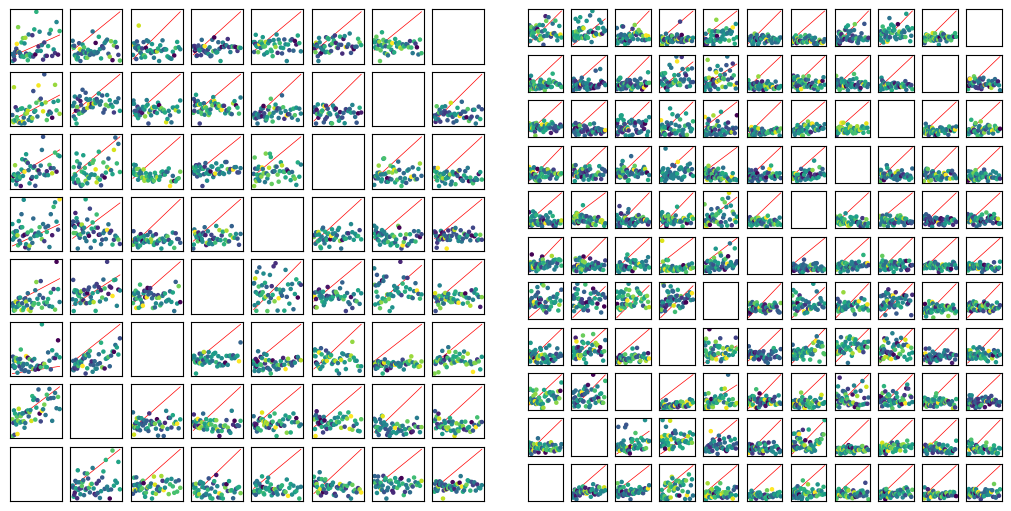

In [35]:
fig = plt.figure(layout='constrained', figsize=(10, 5))

subfigs = fig.subfigures(1, 2, wspace=0.07)

for ell, lineage in enumerate(lineages):
    gt_Q = processed_est_dict[lineage]["gt_Q"]
    samples_Q = processed_est_dict[lineage]["samples_Q"]
    loglik = processed_est_dict[lineage]["loglik"]
    num_pops = processed_est_dict[lineage]["num_pops"]
    
    axs = subfigs[ell].subplots(num_pops, num_pops)    
    
    for i in range(num_pops):
        for j in range(num_pops):
            ii = num_pops-i-1
            ax = axs[ii,j]
            ax.set(xticks=[], yticks=[])
            if i == j:
                continue
            Qij = samples_Q[:,i,j,:]
            mQij = np.median(Qij, axis=-1)
            gt_Qij = gt_Q[:,i,j]
            color = loglik[:,i,j]
            ax.scatter(gt_Qij, mQij, c=color, s=5, zorder=2)
            lQij, uQij = np.percentile(Qij, q=[25, 75], axis=-1)
            ax.plot(gt_Qij, gt_Qij, color='r', zorder=-1, linewidth=0.5)


### Compute correlation coeffs between the "ground truth" and estimates

Make a matrix with correlation coefficients and p-values.

In [ ]:
import scipy.stats as sts

corr_mat_dict = {}
pval_mat_dict = {}

for ell, lineage in enumerate(lineages):
    gt_Q = processed_est_dict[lineage]["gt_Q"]
    samples_Q = processed_est_dict[lineage]["samples_Q"]
    loglik = processed_est_dict[lineage]["loglik"]
    num_pops = processed_est_dict[lineage]["num_pops"]

    corr_mat = np.zeros((num_pops, num_pops))
    pval_mat = np.zeros((num_pops, num_pops))
    
    for i in range(num_pops):
        for j in range(num_pops):
            if i == j:
                continue
            Qij = samples_Q[:,i,j,:]
            mQij = np.median(Qij, axis=-1)
            gt_Qij = gt_Q[:,i,j]
            
            res = sts.spearmanr(np.log(gt_Qij), np.log(mQij))
            corr_mat[i,j] = res.statistic
            
            pval_mat[i,j] = res.pvalue

    corr_mat_dict[lineage] = corr_mat
    pval_mat_dict[lineage] = pval_mat

### Make a heatmap with correlation coeffients

Indicate which correlations are statistically significant

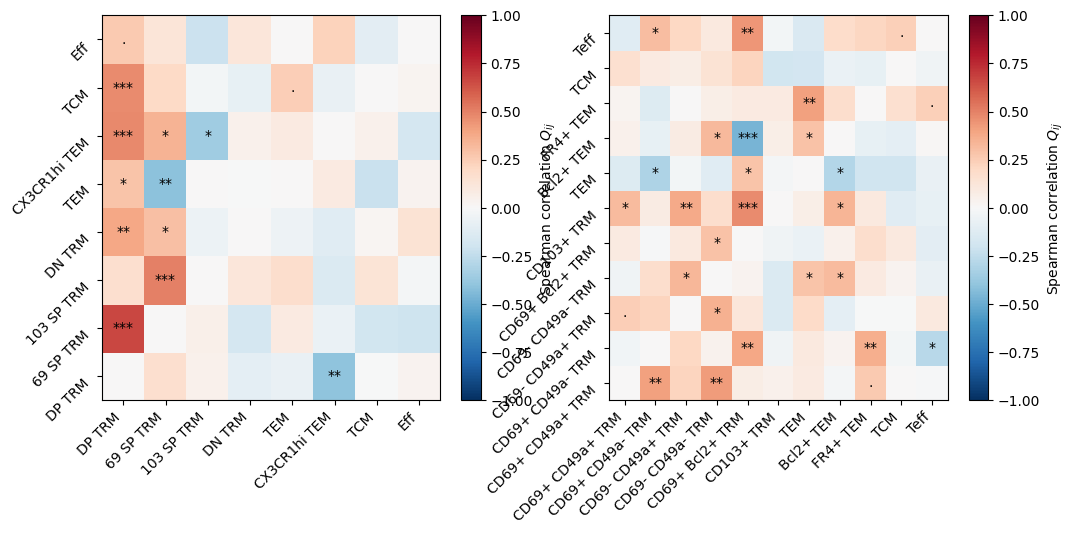

In [14]:
import scdynsys.utilities as utils
import importlib
importlib.reload(utils)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for ell, lineage in enumerate(lineages):
    corr_mat = corr_mat_dict[lineage]
    pval_mat = pval_mat_dict[lineage]

    num_pops = processed_est_dict[lineage]["num_pops"]
    celltype_names = datasets[lineage]["celltype_names"]

    ax = axs[ell]
    
    C = ax.pcolor(corr_mat, cmap='RdBu_r', vmin=-1, vmax=1)
    cx = fig.colorbar(C)
    
    cx.set_label("Spearman correlation $Q_{ij}$")
    
    for i in range(num_pops):
        for j in range(num_pops):
            if i == j:
                continue
            st = utils.sign_stars(pval_mat[i,j])
            ax.text(j+0.5, i+0.5, st, va='center', ha='center')
    
    ticks = np.linspace(0, num_pops-1, num_pops) + 0.5
    ax.set(xticks=ticks, yticks=ticks)
    ax.set_xticklabels(celltype_names, rotation=45, ha='right')
    ax.set_yticklabels(celltype_names, rotation=45, va='top')

## Simulate the model with baseline params and compare Q_gt with estimated Q element-wise

This is a simpler analysis in which we simply re-fit the model to simulated data, and then see how well we can recover individual matrix elements.

In [ ]:
def get_Q_gt_and_est(par_dict_est, pd_gt, num_pops):
    # only use the off-diagonal elements of Q
    dmask = np.eye(num_pops, dtype=bool)
    Q_est_offdiag = par_dict_est["Q"][...,~dmask]
    Q_est_offdiag_med = np.median(Q_est_offdiag, axis=0)
    Q_est_offdiag_low, Q_est_offdiag_high = np.percentile(Q_est_offdiag, q=[25, 75], axis=0)
    Q_gt_offdiag = pd_gt["Q"][~dmask]
    return Q_gt_offdiag, Q_est_offdiag_low, Q_est_offdiag_med, Q_est_offdiag_high


def refit_model_to_sim(lineage):
    rdat = required_data[lineage]
    num_pops = rdat["num_pops"]
    pd_gt = rdat["pd_gt"]
    model = focal_models[lineage]
    t0 = rdat["t0"]
    tobs = rdat["tobs"]
    flow_sample_sizes = rdat["flow_sample_sizes"]
    count_scaling = datasets[lineage]["count_scaling"]

    print(f"simulating data for lineage {lineage}")
    
    sim = ident.generate_pseudo_data(model, pd_gt, t0, tobs, flow_sample_sizes, count_scaling)
    # add model and count_scaling to sim
    sim["model"] = model
    sim["count_scaling"] = count_scaling
    
    print(f"fitting model to pseudo data for lineage {lineage}")

    stan_kwargs = {"iter_sampling" : 200, "iter_warmup" : 200, "adapt_delta" : 0.99}
    par_dict, inits, stan_data, diag_dict = ident.fit_model_to_psuedo_data(**sim, stan_kwargs=stan_kwargs)

    print("plotting results")
    
    ## plot for Q values
    fig, ax = plt.subplots(1, 1, figsize=(3,3))
    Q_gt_offdiag, Q_est_offdiag_low, Q_est_offdiag_med, Q_est_offdiag_high = get_Q_gt_and_est(par_dict, pd_gt, num_pops)
    ax.scatter(Q_gt_offdiag, Q_est_offdiag_med, s=1, color='k')
    for i, x in enumerate(Q_gt_offdiag):
        l, u = Q_est_offdiag_low[i], Q_est_offdiag_high[i]
        ax.plot([x, x], [l, u], color='k', linewidth=0.5)
    
    ax.plot([1e-3, 0.11], [1e-3, 0.11], color='r', linewidth=0.5)

    res_dict = {
        "Q_gt_offdiag" : Q_gt_offdiag, 
        "Q_est_offdiag_low" : Q_est_offdiag_low, 
        "Q_est_offdiag_med" : Q_est_offdiag_med, 
        "Q_est_offdiag_high" : Q_est_offdiag_high,
    }
    
    return res_dict

### Simulate and re-fit the models

<div class="alert alert-block alert-info"> <b>NOTE</b> 
    This may take some time...
</div>

simulating data for lineage CD8
fitting model to pseudo data for lineage CD8


14:00:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 5 |          | 00:00 Status

14:21:04 - cmdstanpy - INFO - CmdStan done processing.
14:21:04 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 3 iterations at max treedepth (1.5%)
	Chain 3 had 1 iterations at max treedepth (0.5%)
	Chain 5 had 9 iterations at max treedepth (4.5%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.



plotting results
simulating data for lineage CD4
fitting model to pseudo data for lineage CD4


14:21:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 5 |          | 00:00 Status

14:29:34 - cmdstanpy - INFO - CmdStan done processing.


14:29:34 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 iterations at max treedepth (0.5%)
	Chain 3 had 3 iterations at max treedepth (1.5%)
	Chain 5 had 1 iterations at max treedepth (0.5%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


plotting results


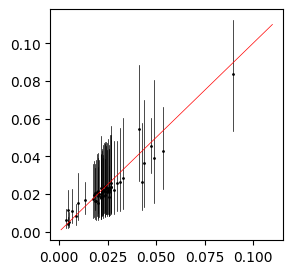

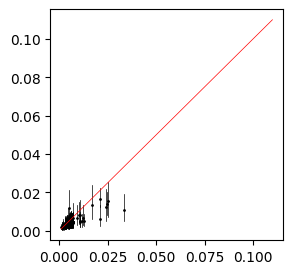

In [20]:
refit_Q_estimates = {}

for lineage in lineages:
    res = refit_model_to_sim(lineage)
    refit_Q_estimates[lineage] = res

## Save data for SI figure

In [21]:
ident_data_dict = {
    "corr_mat_dict" : corr_mat_dict,
    "pval_mat_dict" : pval_mat_dict,
    "refit_Q_estimates" : refit_Q_estimates
}

with open("../results/data_figure_ident.pkl", 'wb') as f:
    pickle.dump(ident_data_dict, f)